# Importing the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None 

import string
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BOBBY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\BOBBY\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
from bs4 import BeautifulSoup
from tqdm import tqdm

tqdm.pandas()

c:\users\bobby\appdata\local\programs\python\python37\lib\site-packages\tqdm\std.py:725: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
from collections import Counter
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from pprint import pprint
from gensim.models.coherencemodel import CoherenceModel

In [5]:
import os
from gensim.models.wrappers import LdaMallet
os.environ['MALLET_HOME'] = 'C:\\Users\\BOBBY\\Downloads\\mallet-2.0.8'
mallet_path = 'C:\\Users\\BOBBY\\Downloads\\mallet-2.0.8\\bin\\mallet'

# Importing the datasets

In [6]:
#The whole dataset is in the data folder in 5 different files
df1 = pd.read_csv('data/original_data1.csv')
df2 = pd.read_csv('data/original_data2.csv')
df3 = pd.read_csv('data/original_data3.csv')
df4 = pd.read_csv('data/original_data4.csv')
df5 = pd.read_csv('data/original_data5.csv')

In [7]:
#All the different data from differnt datasets is concatenated to form a single dataset
df = pd.concat([df1,df2,df3,df4,df5], axis=0)

In [8]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [9]:
df.reset_index(drop=True, inplace=True)

In [10]:
df

,id,title,body,tags,answers,score
0,62766758,"How to fix Python error ""...failed to map segm...",<p>I've recently started to use Google Cloud P...,python-3.x|pandas|shell|numpy|google-cloud-pla...,<p>Container-Optimized OS (COS) has several li...,1
1,62766758,"How to fix Python error ""...failed to map segm...",<p>I've recently started to use Google Cloud P...,python-3.x|pandas|shell|numpy|google-cloud-pla...,<p>I'm pretty sure that in case of Python libr...,0
2,62742938,Wrapper for 'python -m' command,<p>I have a package with following structure:<...,python|modulenotfounderror,"<p>The standard library has a module <a href=""...",1
3,62741826,How can I improve the speed of pandas rows ope...,<p>I have a large .csv file that has 11'000'00...,python|pandas|performance|data-science,<p>Hello and welcome to StackOverflow.</p>\r\n...,1
4,62741826,How can I improve the speed of pandas rows ope...,<p>I have a large .csv file that has 11'000'00...,python|pandas|performance|data-science,<p>I guess you want to <code>groupby</code> an...,0
...,...,...,...,...,...,...
99995,35898687,Adding column to PySpark DataFrame depending o...,<p>I have a PySpark DataFrame with structure g...,python|apache-spark|pyspark|apache-spark-sql,<p>Just for fun non-UDF solution:</p>\r\n\r\n<...,3
99996,35898687,Adding column to PySpark DataFrame depending o...,<p>I have a PySpark DataFrame with structure g...,python|apache-spark|pyspark|apache-spark-sql,<p>The following code does the requested task....,7
99997,35937882,Simple Window using TkInter,<p>I'm new to <code>TkInter</code> and using P...,python|python-2.7|user-interface|tkinter,"<p>At the end of your code, just add <code>win...",2
99998,35937882,Simple Window using TkInter,<p>I'm new to <code>TkInter</code> and using P...,python|python-2.7|user-interface|tkinter,<p>You didn't do a </p>\r\n\r\n<pre><code>wind...,5


# Understanding the dataset

For this model, we want to label the answers, so we will be needing only the 'id', 'tags' and 'answers' columns. Other columns are ignored. The required columns are copied into another dataframe, so the original dataframe can be used when required. 

In [11]:
data = df[['id','tags','answers']]

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
id         100000 non-null int64
tags       100000 non-null object
answers    100000 non-null object
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


In [13]:
data.isnull().sum()

id         0
tags       0
answers    0
dtype: int64

In [14]:
min_ans_len = data['answers'].str.len().min()
max_ans_len = data['answers'].str.len().max()

In [15]:
data[data['answers'].str.len()==min_ans_len]

,id,tags,answers
43053,4350260,python|inheritance|decorator,"<p>No, it doesn't.</p>"


In [16]:
data[data['answers'].str.len()==max_ans_len]

,id,tags,answers
87503,64587303,python|numpy|image-processing|convolution,<p>I've implemented several very fast solution...


# Text Processing

In [17]:
data['tags'] = data['tags'].str.replace('|',' ')
data['tags'] = data['tags'].str.replace('python-3.x','python')
data['tags'] = data['tags'].str.replace('python-2.7','python')

In [18]:
#def parser(text):
#    soup = BeautifulSoup(text, 'html.parser')
#    while(soup.code):
#        soup.code.decompose()
#    return soup.text

In [19]:
def extract_text(text):
    soup = BeautifulSoup(text, 'lxml')
    txt = "".join([txt.text for txt in soup.find_all("p")])
    return txt

In [20]:
def extract_link(text):
    soup = BeautifulSoup(text, 'lxml')
    link = " ".join([link['href'] for link in soup.find_all("a")])
    return link

In [21]:
def extract_code(text):
    soup = BeautifulSoup(text, 'lxml')
    code = "\n".join([code.text for code in soup.find_all("code")])
    return code

In [22]:
#extracting text
data['text'] = data['answers'].apply(extract_text)
#extracting links
data['link'] = data['answers'].apply(extract_link)
#extracting links
data['code'] = data['answers'].apply(extract_code)
#extracting question body
df['body'] = df['body'].apply(extract_text)

In [23]:
data['ans_tokenized'] = data['text']

In [24]:
#converting all letters to lowercase
data['ans_tokenized'] = data['ans_tokenized'].str.lower()
data['tags'] = data['tags'].str.lower()

In [25]:
#removing all punctuations
data['ans_tokenized'] = data['ans_tokenized'].str.translate(str.maketrans("", "", string.punctuation))
data['tags'] = data['tags'].str.translate(str.maketrans("", "", string.punctuation))

In [26]:
data

,id,tags,answers,text,link,code,ans_tokenized
0,62766758,python pandas shell numpy googlecloudplatform,<p>Container-Optimized OS (COS) has several li...,Container-Optimized OS (COS) has several limit...,https://cloud.google.com/container-optimized-o...,,containeroptimized os cos has several limitati...
1,62766758,python pandas shell numpy googlecloudplatform,<p>I'm pretty sure that in case of Python libr...,I'm pretty sure that in case of Python librari...,,failed to map segment from shared object\n.so\...,im pretty sure that in case of python librarie...
2,62742938,python modulenotfounderror,"<p>The standard library has a module <a href=""...",The standard library has a module runpy for th...,https://docs.python.org/3/library/runpy.html,"runpy\nimport runpy\r\nrunpy.run_module(""my_pa...",the standard library has a module runpy for th...
3,62741826,python pandas performance datascience,<p>Hello and welcome to StackOverflow.</p>\r\n...,Hello and welcome to StackOverflow.In pandas t...,,groupby\nS\nIn [37]: def my_func(df): \r\n ...,hello and welcome to stackoverflowin pandas th...
4,62741826,python pandas performance datascience,<p>I guess you want to <code>groupby</code> an...,I guess you want to groupby and exclude all th...,,groupby\nmixid2\nset_index\nreset_index\ndf = ...,i guess you want to groupby and exclude all th...
...,...,...,...,...,...,...,...
99995,35898687,python apachespark pyspark apachesparksql,<p>Just for fun non-UDF solution:</p>\r\n\r\n<...,Just for fun non-UDF solution:So it just:unrol...,,"from pyspark.sql.functions import col, first, ...",just for fun nonudf solutionso it justunrolls ...
99996,35898687,python apachespark pyspark apachesparksql,<p>The following code does the requested task....,The following code does the requested task. An...,,DataFrame\n# Imports\r\nfrom pyspark.sql.types...,the following code does the requested task an ...
99997,35937882,python python userinterface tkinter,"<p>At the end of your code, just add <code>win...","At the end of your code, just add window.mainl...",,window.mainloop(),at the end of your code just add windowmainloo...
99998,35937882,python python userinterface tkinter,<p>You didn't do a </p>\r\n\r\n<pre><code>wind...,You didn't do a at the end. Check the Tkinter ...,https://docs.python.org/2/library/tkinter.html,window.mainloop() \r\n,you didnt do a at the end check the tkinter do...


In [27]:
stem_word_list = [('np ', 'numpy '), ('plt', 'plot'), ('correctly', 'correct'), ('containing', 'contain'), ('better', 'good'),
                  ('best', 'good'), ('strings', 'string'), ('arrays', 'array'), ('variables', 'variable'), ('calls', 'call'), 
                  ('called', 'call'), ('calling', 'call'), ('returns', 'return'), ('results', 'result'), ('values', 'value'), 
                  ('val ', 'value '), ('images', 'image'), ('img', 'image'), ('png', 'image'), ('tuples', 'tuple'), ('arguments', 'argument'), 
                  ('args', 'argument'), ('argv', 'argument'), ('parameters ', 'parameter'), ('params ', 'parameter'), ('param ', 'parameter'), 
                  ('prints', 'print'), ('lists', 'list'), ('runs', 'run'), ('models', 'model'), ('headers', 'header'), ('installation', 'install'), 
                  ('installed','install'), ('tf','tensorflow'), ('found', 'find'), ('lines', 'line'), ('pd', 'pandas'), 
                  ('df', 'dataframe'), ('lib ', 'library '), ('https', 'http'), ('works', 'work'), ('classes', 'class'), 
                  ('follows', 'follow'), ('numbers', 'number'), ('points', 'point'), ('dict ', 'dictionary'), ('characters', 'character'),
                  ('keys', 'key'), ('bytes', 'byte'), ('str ', 'string'), ('objects', 'objects'), ('methods', 'method'),
                 ('rows', 'row'), ('defined', 'define'), ('cases', 'case'), ('names', 'name'), ('helps', 'help')]

In [28]:
for (word, repl_word) in stem_word_list:
    data['ans_tokenized'] = data['ans_tokenized'].str.replace(word, repl_word)

In [29]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BOBBY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
docs = data['ans_tokenized'].tolist()

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

cv = CountVectorizer(max_df=0.65, stop_words = stop_words)
word_count_vector = cv.fit_transform(docs)

In [32]:
tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit_transform(word_count_vector)

<100000x207651 sparse matrix of type '<class 'numpy.float64'>'
	with 2303037 stored elements in Compressed Sparse Row format>

In [33]:
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(), columns=["idf_weights"]) 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
use,2.195287
using,2.723177
like,2.806680
need,2.871072
python,2.883951
...,...
hereresulting,11.819788
hererfecv,11.819788
hererobin,11.819788
heremvc,11.819788


In [34]:
#tokenizing text
data['ans_tokenized'] = data['ans_tokenized'].apply(lambda text: [word for word in nltk.word_tokenize(text) if word.isalpha()])

In [35]:
for i in range(0,data.shape[0]):
    data['tags'][i] = data['tags'][i].split(' ')

In [36]:
#function for filtering stop words
def filter_stop_words(words):
    words_filtered = []
    for word in words:
        if word not in stop_words:
            words_filtered.append(word)
    return words_filtered

In [37]:
stop_words.update(df_idf[df_idf['idf_weights']<5].index)
stop_words.update(['may', 'non', 'v', 'l', 'e', 'g', 'rw', 'r', 'xr', 'x', 'rwxr', 'still', 'much', 'c', 'p', 'n', 'k', 'b', 'h', 'f',
                   'lot', 'us', 'kind', 'q', 'w', 'z', 'en', 'ax', 'j', 'python', 'code', 'using', 'need', 'get', 'py', 'u', 'keep', 
                   'also', 'really', 'able', 'maybe', 'things', 'everything', 'happens', 'actually', 'lst', 'already',
                  'within', 'li', 'python', 'based', 'user', 'np', 'pd', 'tf', 'id', 'work', 'write', 'df', 'np', 'pd', 'make',
                  'said', 'gets', 'en', 'thus', 'dataframe', 'pandas', 'numpy', 'django', 'html', 'string', 'variable', 'javascript',
                   'function', 'class', 'file', 'unicode', 'index', 'column', 'row', 'list', 'array','set', 'argument', 'method',
                   'parameter', 'loop', 'array', 'key', 'value', 'element', 'return', 'xml', 'tkinter', 'dict', 'dictionary', 'character',
                   'byte', 'regex', 'hello', 'stackoverflow', 'tuple', 'module', 'tensorflow', 'json'])
data['ans_tokenized'] = data['ans_tokenized'].apply(filter_stop_words)

In [38]:
data

,id,tags,answers,text,link,code,ans_tokenized
0,62766758,"[python, pandas, shell, numpy, googlecloudplat...",<p>Container-Optimized OS (COS) has several li...,Container-Optimized OS (COS) has several limit...,https://cloud.google.com/container-optimized-o...,,"[containeroptimized, os, cos, several, limitat..."
1,62766758,"[python, pandas, shell, numpy, googlecloudplat...",<p>I'm pretty sure that in case of Python libr...,I'm pretty sure that in case of Python librari...,,failed to map segment from shared object\n.so\...,"[pretty, libraries, natives, message, failed, ..."
2,62742938,"[python, modulenotfounderror]","<p>The standard library has a module <a href=""...",The standard library has a module runpy for th...,https://docs.python.org/3/library/runpy.html,"runpy\nimport runpy\r\nrunpy.run_module(""my_pa...","[standard, runpy, purpose, contain, justand, b..."
3,62741826,"[python, pandas, performance, datascience]",<p>Hello and welcome to StackOverflow.</p>\r\n...,Hello and welcome to StackOverflow.In pandas t...,,groupby\nS\nIn [37]: def my_func(df): \r\n ...,"[welcome, stackoverflowin, rule, thumb, raw, l..."
4,62741826,"[python, pandas, performance, datascience]",<p>I guess you want to <code>groupby</code> an...,I guess you want to groupby and exclude all th...,,groupby\nmixid2\nset_index\nreset_index\ndf = ...,"[guess, groupby, exclude, appears, times, seti..."
...,...,...,...,...,...,...,...
99995,35898687,"[python, apachespark, pyspark, apachesparksql]",<p>Just for fun non-UDF solution:</p>\r\n\r\n<...,Just for fun non-UDF solution:So it just:unrol...,,"from pyspark.sql.functions import col, first, ...","[fun, nonudataframe, solutionso, justunrolls, ..."
99996,35898687,"[python, apachespark, pyspark, apachesparksql]",<p>The following code does the requested task....,The following code does the requested task. An...,,DataFrame\n# Imports\r\nfrom pyspark.sql.types...,"[requested, task, receives, columns, parameter..."
99997,35937882,"[python, python, userinterface, tkinter]","<p>At the end of your code, just add <code>win...","At the end of your code, just add window.mainl...",,window.mainloop(),"[windowmainloop, tells, form, ready, shown]"
99998,35937882,"[python, python, userinterface, tkinter]",<p>You didn't do a </p>\r\n\r\n<pre><code>wind...,You didn't do a at the end. Check the Tkinter ...,https://docs.python.org/2/library/tkinter.html,window.mainloop() \r\n,"[didnt, docs, docs]"


Some of the words are not useful, which are therefore added to the list of 'stop_words' and the answer text is filtered.

In [39]:
answers = data['ans_tokenized']

In [40]:
answers

0        [containeroptimized, os, cos, several, limitat...
1        [pretty, libraries, natives, message, failed, ...
2        [standard, runpy, purpose, contain, justand, b...
3        [welcome, stackoverflowin, rule, thumb, raw, l...
4        [guess, groupby, exclude, appears, times, seti...
                               ...                        
99995    [fun, nonudataframe, solutionso, justunrolls, ...
99996    [requested, task, receives, columns, parameter...
99997          [windowmainloop, tells, form, ready, shown]
99998                                  [didnt, docs, docs]
99999    [whenever, faced, complex, consider, xslt, tra...
Name: ans_tokenized, Length: 100000, dtype: object

# Building the model

In [41]:
#Create dictionary and corpus
id2word = corpora.Dictionary(answers)
corpus = [id2word.doc2bow(answer) for answer in answers]

In [42]:
id2word

In [43]:
#Building an lda model
ldamodel = LdaMulticore(corpus=corpus, num_topics=8, id2word=id2word, passes=5)

In [44]:
pprint(ldamodel.show_topics(formatted=False))

[(0,
  [('package', 0.011310568),
   ('directory', 0.010319675),
   ('pip', 0.007586818),
   ('csv', 0.005464666),
   ('header', 0.0050807386),
   ('packages', 0.0045026904),
   ('build', 0.0035642404),
   ('search', 0.003382492),
   ('copy', 0.0033179352),
   ('source', 0.0031177367)]),
 (1,
  [('match', 0.0064066425),
   ('attribute', 0.0056833443),
   ('expression', 0.0049996977),
   ('word', 0.0048025255),
   ('field', 0.004001216),
   ('words', 0.0035695953),
   ('regular', 0.0035532487),
   ('attributes', 0.0029858907),
   ('generator', 0.0028799232),
   ('matches', 0.0028104722)]),
 (2,
  [('server', 0.00941304),
   ('page', 0.0061515947),
   ('request', 0.006042228),
   ('app', 0.005764353),
   ('thread', 0.0053996397),
   ('database', 0.005315564),
   ('application', 0.0045817182),
   ('api', 0.0043635615),
   ('url', 0.004169856),
   ('send', 0.004169847)]),
 (3,
  [('global', 0.009242334),
   ('date', 0.00812623),
   ('datetime', 0.0060931765),
   ('statement', 0.005831627),

In [45]:
ldamodel.log_perplexity(corpus)

-10.01231755265589

In [46]:
coherence_lda = CoherenceModel(model=ldamodel, texts=answers, dictionary=id2word, coherence='c_v')
score = coherence_lda.get_coherence()

In [47]:
print("Coherence score of lda model: ",score)

Coherence score of lda model:  0.4435785082477143


In [48]:
ldamallet_model = LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word, alpha = 1
                            , random_seed = 121)

In [49]:
pprint(ldamallet_model.show_topics(formatted=False))

[(0,
  [('attribute', 0.006567047603387322),
   ('int', 0.005821960042752611),
   ('integer', 0.005698635205130313),
   ('encoding', 0.0050511798076132534),
   ('reference', 0.0048970237605853815),
   ('float', 0.004629819945737071),
   ('global', 0.004527049247718491),
   ('true', 0.004378031735591548),
   ('syntax', 0.00382820850119214),
   ('attributes', 0.0036894680588670558)]),
 (1,
  [('match', 0.009369432099776772),
   ('columns', 0.00881136210039116),
   ('item', 0.007874418890413484),
   ('comprehension', 0.007766900817137357),
   ('items', 0.0073521882487865816),
   ('iterate', 0.00730098916627414),
   ('split', 0.007167871551741793),
   ('word', 0.006369165864547707),
   ('group', 0.006220688525261627),
   ('expression', 0.006159249626246698)]),
 (2,
  [('memory', 0.008313576877920972),
   ('faster', 0.0049863329147835705),
   ('performance', 0.00436984084531942),
   ('language', 0.004338109635861707),
   ('implementation', 0.00401626451136204),
   ('large', 0.00349949910019

In [50]:
coherence_ldamallet = CoherenceModel(model=ldamallet_model, texts=answers, dictionary=id2word, coherence='c_v')
score = coherence_ldamallet.get_coherence()

In [51]:
print("Coherence score of lda mallet model: ",score)

Coherence score of lda mallet model:  0.543741716351073


By comparing the scores, it is clearly evident that LDA Mallet model works better that LDA multicore model. We can use LDA mallet model and find optimal number of topics.

# Finding optimal number of topics

In [166]:
def coh_value(id2word, corpus, answers, start, stop, step):
    coh_values_list = []
    model_list = []
    for num_topics in range(start, stop, step):
        model = LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, alpha = 1, random_seed=11)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=answers, dictionary=id2word, coherence='c_v')
        coh_values_list.append(coherencemodel.get_coherence())
        print(num_topics)
    return model_list, coh_values_list

In [167]:
start = 2
stop = 20
step = 3

In [168]:
model_list, coh_values_list = coh_value(id2word, corpus, answers, start, stop, step)

2
5
8
11
14
17


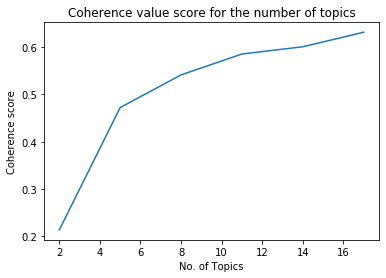

In [169]:
topic_num = range(start, stop, step)
plt.plot(topic_num, coh_values_list)
plt.title("Coherence value score for the number of topics")
plt.xlabel("No. of Topics")
plt.ylabel("Coherence score")
#plt.legend(("coherence_values"), loc='best')
plt.show()

In [171]:
for i in range(start, stop, step):
    print("No. of topics:  ", i, ", Coherence Value: ", coh_values_list[(i-start)//3])

No. of topics:   2 , Coherence Value:  0.2136187901023405
No. of topics:   5 , Coherence Value:  0.4723783990208732
No. of topics:   8 , Coherence Value:  0.5414492003912681
No. of topics:   11 , Coherence Value:  0.5856094200409331
No. of topics:   14 , Coherence Value:  0.6009304937062198
No. of topics:   17 , Coherence Value:  0.631654452929848


In [52]:
final_model = model_list[2]
model_topics = final_model.show_topics(formatted=False)
pprint(final_model.print_topics(num_words=10))

[(0,
  '0.007*"attribute" + 0.006*"int" + 0.006*"integer" + 0.005*"encoding" + '
  '0.005*"reference" + 0.005*"float" + 0.005*"global" + 0.004*"true" + '
  '0.004*"syntax" + 0.004*"attributes"'),
 (1,
  '0.009*"match" + 0.009*"columns" + 0.008*"item" + 0.008*"comprehension" + '
  '0.007*"items" + 0.007*"iterate" + 0.007*"split" + 0.006*"word" + '
  '0.006*"group" + 0.006*"expression"'),
 (2,
  '0.008*"memory" + 0.005*"faster" + 0.004*"performance" + 0.004*"language" + '
  '0.004*"implementation" + 0.003*"large" + 0.003*"pretty" + 0.003*"easy" + '
  '0.003*"small" + 0.003*"speed"'),
 (3,
  '0.015*"server" + 0.012*"request" + 0.010*"page" + 0.009*"url" + 0.009*"api" '
  '+ 0.008*"app" + 0.008*"requests" + 0.007*"client" + 0.006*"web" + '
  '0.006*"send"'),
 (4,
  '0.009*"thread" + 0.008*"exception" + 0.007*"main" + 0.007*"event" + '
  '0.006*"block" + 0.006*"statement" + 0.006*"open" + 0.005*"window" + '
  '0.005*"threads" + 0.005*"button"'),
 (5,
  '0.016*"directory" + 0.014*"package" +

# Creating answer dataset with topics

In [53]:
topics = final_model[corpus]

In [54]:
topics

[[(0, 0.024522569444444444),
  (1, 0.005425347222222222),
  (2, 0.189453125),
  (3, 0.003689236111111111),
  (4, 0.001953125),
  (5, 0.7102864583333334),
  (6, 0.060980902777777776),
  (7, 0.003689236111111111)],
 [(0, 0.057950191570881236),
  (1, 0.011973180076628355),
  (2, 0.04262452107279694),
  (3, 0.03496168582375479),
  (4, 0.01580459770114943),
  (5, 0.724616858237548),
  (6, 0.10775862068965518),
  (7, 0.004310344827586208)],
 [(0, 0.064484126984127),
  (1, 0.016865079365079368),
  (2, 0.14384920634920637),
  (3, 0.024801587301587304),
  (4, 0.00892857142857143),
  (5, 0.7232142857142858),
  (6, 0.00892857142857143),
  (7, 0.00892857142857143)],
 [(0, 0.0886437908496732),
  (1, 0.6441993464052288),
  (2, 0.23243464052287582),
  (3, 0.003676470588235294),
  (4, 0.010212418300653595),
  (5, 0.003676470588235294),
  (6, 0.003676470588235294),
  (7, 0.013480392156862746)],
 [(0, 0.0125),
  (1, 0.6791666666666667),
  (2, 0.02361111111111111),
  (3, 0.034722222222222224),
  (4, 0.03

In [55]:
topic_df = pd.DataFrame()

In [56]:
for i, topic_vector in enumerate(topics):
    topic_list = []
    topic_vector = sorted(topic_vector, key = lambda topic: (topic[1]), reverse=True)
    for j, (topic_num, prob) in enumerate(topic_vector):
        prob = round(prob,2)*100
        if(prob > 14):
            topic = "Topic " + str(topic_num)
            topic_list.append(topic)
        else:
            break
    topics_col = ", ".join([topic for topic in topic_list])
    if(i%1000==0): print(i)
    topic_df = topic_df.append(pd.Series([df.iloc[i]['id'], df.iloc[i]['body'], data.iloc[i]['text'], data.iloc[i]['link'], data.iloc[i]['code'], topics_col, df.iloc[i]['score']]), ignore_index=True) 

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000


In [57]:
topic_df

,0,1,2,3,4,5,6
0,62766758.0,I've recently started to use Google Cloud Plat...,Container-Optimized OS (COS) has several limit...,https://cloud.google.com/container-optimized-o...,,"Topic 5, Topic 2",1.0
1,62766758.0,I've recently started to use Google Cloud Plat...,I'm pretty sure that in case of Python librari...,,failed to map segment from shared object\n.so\...,Topic 5,0.0
2,62742938.0,I have a package with following structure:I'm ...,The standard library has a module runpy for th...,https://docs.python.org/3/library/runpy.html,"runpy\nimport runpy\r\nrunpy.run_module(""my_pa...","Topic 5, Topic 2",1.0
3,62741826.0,I have a large .csv file that has 11'000'000 r...,Hello and welcome to StackOverflow.In pandas t...,,groupby\nS\nIn [37]: def my_func(df): \r\n ...,"Topic 1, Topic 2",1.0
4,62741826.0,I have a large .csv file that has 11'000'000 r...,I guess you want to groupby and exclude all th...,,groupby\nmixid2\nset_index\nreset_index\ndf = ...,"Topic 1, Topic 6",0.0
...,...,...,...,...,...,...,...
99995,35898687.0,I have a PySpark DataFrame with structure give...,Just for fun non-UDF solution:So it just:unrol...,,"from pyspark.sql.functions import col, first, ...",Topic 1,3.0
99996,35898687.0,I have a PySpark DataFrame with structure give...,The following code does the requested task. An...,,DataFrame\n# Imports\r\nfrom pyspark.sql.types...,"Topic 1, Topic 4",7.0
99997,35937882.0,I'm new to TkInter and using Python to develop...,"At the end of your code, just add window.mainl...",,window.mainloop(),"Topic 4, Topic 7",2.0
99998,35937882.0,I'm new to TkInter and using Python to develop...,You didn't do a at the end. Check the Tkinter ...,https://docs.python.org/2/library/tkinter.html,window.mainloop() \r\n,"Topic 7, Topic 5",5.0


In [59]:
topic_df.columns = ['id', 'body', 'answer', 'link', 'code', 'topic list', 'score']

In [60]:
topic_df.to_csv('data/keyword_answer.csv', index=False)

# Creating dataset for topics and its keywords

In [61]:
keyword_df = pd.DataFrame()

In [62]:
for topic_num in range(0,8):
    topic_keyword_list = final_model.show_topic(topic_num)
    keyword_list = []
    for word in topic_keyword_list:
        keyword_list.append(word[0])
    keyword_list = ', '.join(keyword_list)
    keyword_df = keyword_df.append(pd.Series(["Topic "+str(topic_num), keyword_list]), ignore_index=True)

In [63]:
keyword_df.columns = ['Topic', 'Keywords']

In [64]:
keyword_df

,Topic,Keywords
0,Topic 0,"attribute, int, integer, encoding, reference, ..."
1,Topic 1,"match, columns, item, comprehension, items, it..."
2,Topic 2,"memory, faster, performance, language, impleme..."
3,Topic 3,"server, request, page, url, api, app, requests..."
4,Topic 4,"thread, exception, main, event, block, stateme..."
5,Topic 5,"directory, package, pip, windows, environment,..."
6,Topic 6,"size, matrix, plot, shape, graph, axis, labels..."
7,Topic 7,"field, table, database, query, csv, template, ..."


In [65]:
keyword_df.to_csv('data/keywords.csv', index=False)